In [ ]:
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS

#Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re # import the regular expression module
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
df = pd.read_csv('mbti_1.csv')

In [ ]:
# Load your data
#df = pd.read_csv('/content/drive/MyDrive/Personality_ML/mbti_1.csv')
X = df['posts']
y = df['type']
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
df.tail()

,type,posts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...
8674,INFP,'It has been too long since I have been on per...


In [ ]:
df.isnull().any()

,0
type,False
posts,False


In [ ]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 8675 rows and 2 columns


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [ ]:
df.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


In [ ]:
types = np.unique(np.array(df['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [ ]:
total = df.groupby(['type']).count()*50
total

,posts
type,
ENFJ,9500
ENFP,33750
ENTJ,11550
ENTP,34250
ESFJ,2100
ESFP,2400
ESTJ,1950
ESTP,4450
INFJ,73500


Text(0.5, 1.0, 'Total posts for each personality type')

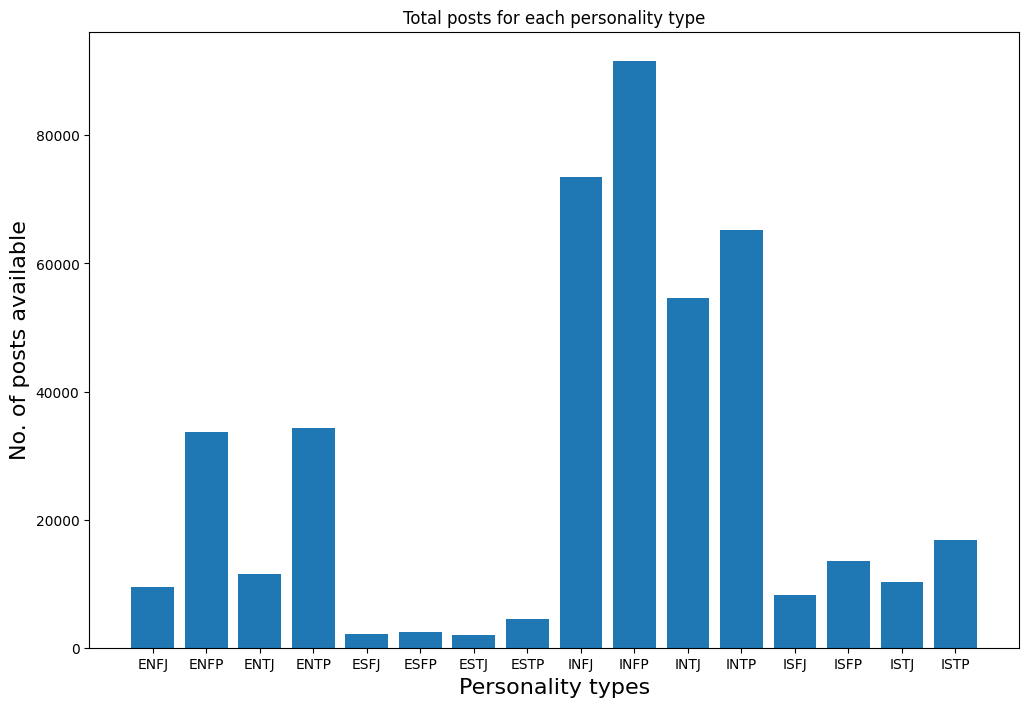

In [ ]:
plt.figure(figsize = (12,8))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 16)
plt.ylabel('No. of posts available', size = 16)
plt.title('Total posts for each personality type')

In [ ]:
def preprocess_text(df, remove_special=True):
    #Remove links
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))

    #Keep the End Of Sentence characters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))

    #Remove multiple fullstops
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Strip Punctation and digits
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert posts to lowercase
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repeating words(3 or more)
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x))

    #Remove very short or long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) #remove words with (1 to 3) characters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,})\b','',x)) #remove words with 30 or more characters
    return df

#Preprocessing of entered Text
new_df = preprocess_text(df)

#Remove posts with less than X words
min_words = 15
print("Before : Number of posts", len(new_df))
new_df["no. of. words"] = new_df["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
new_df = new_df[new_df["no. of. words"] >= min_words]

print("After : Number of posts", len(new_df))

Before : Number of posts 8675
After : Number of posts 8466


In [ ]:
new_df.head()

,type,posts,no. of. words
0,INFJ,enfp intj moments sportscenter plays...,430
1,ENTP,finding lack these posts very alarming eo...,803
2,INTP,good course which know thats bles...,253
3,INTJ,dear intp enjoyed conversation other eos...,777
4,ENTJ,youre fired eostokendot thats another silly...,402


In [ ]:
# Import necessary libraries
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Download the punkt_tab tokenizer for word_tokenize
nltk.download('punkt_tab')

#Initialize the stemmer (Porter Stemmer in this case)
stemmer = PorterStemmer()

# Apply stemming to the text data
def stem_text(posts):
    # Tokenize the text (split into words)
    words = word_tokenize(posts)

    # Stem each word and return the result
    return ' '.join([stemmer.stem(word) for word in words])

# Apply the stemming function to each row of the 'text' column
df['stemmed_posts'] = df['posts'].apply(stem_text)

# Display the original and stemmed text
new_df = df[['posts', 'stemmed_posts']].copy() # Create a new dataframe from the selected columns
print(new_df)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                                  posts  \
0         enfp  intj moments   sportscenter    plays...   
1      finding  lack    these posts very alarming eo...   
2     good         course  which    know thats  bles...   
3     dear intp    enjoyed  conversation  other  eos...   
4     youre fired eostokendot    thats another silly...   
...                                                 ...   
8670    ixfp just because  always think  cats   doms...   
8671   eostokendot  eostokendot  eostokendot  this t...   
8672   many questions when   these things eostokendo...   
8673    very conflicted right  when  comes  wanting ...   
8674    been  long since  have been  personalitycafe...   

                                          stemmed_posts  
0     enfp intj moment sportscent play prank what be...  
1     find lack these post veri alarm eostokendot bo...  
2     good cours which know that bless curs eostoken...  
3     dear intp enjoy convers other eostokendot esot...  
4

In [ ]:
# Converting MBTI personality (or target or Y feature) into numerical form using Label Encoding
# encoding personality type

enc=LabelEncoder()
new_df['type of encoding'] = enc.fit_transform(df['type'])
target = new_df['type of encoding']
train = new_df['posts']
new_df.head()

,posts,stemmed_posts,type of encoding
0,enfp intj moments sportscenter plays...,enfp intj moment sportscent play prank what be...,8
1,finding lack these posts very alarming eo...,find lack these post veri alarm eostokendot bo...,3
2,good course which know thats bles...,good cours which know that bless curs eostoken...,11
3,dear intp enjoyed conversation other eos...,dear intp enjoy convers other eostokendot esot...,10
4,youre fired eostokendot thats another silly...,your fire eostokendot that anoth silli misconc...,2


In [ ]:
# Assuming 'train' contains text data, transform it using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(train)
train.shape

(8675,)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size=0.3, random_state=2)
print("Shape of x_train",X_train.shape)
print("Shape of y_train",Y_train.shape)
print("Shape of x_test",X_test.shape)
print("Shape of y_test",Y_test.shape)


Shape of x_train (6072, 5000)
Shape of y_train (6072,)
Shape of x_test (2603, 5000)
Shape of y_test (2603,)


In [ ]:
from sklearn.model_selection import cross_val_score

# Initialize the model (RandomForestClassifier in this case)
model = SGDClassifier()

# Perform K-fold cross-validation (e.g., K=5)
k = 5
# Use Y_train instead of Y_test for cross-validation
cv_scores = cross_val_score(model, X_train, Y_train, cv=k, scoring='accuracy')

# Print cross-validation results
print(f'Accuracy for each fold: {cv_scores}')
print(f'Average accuracy: {np.mean(cv_scores) * 100:.2f}%')

Accuracy for each fold: [0.57366255 0.56872428 0.57742998 0.55766063 0.57660626]
Average accuracy: 57.08%


In [ ]:
accuracies = {}
#Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state = 42)
random_forest.fit(X_train, Y_train)

# make predictions for test data
Y_pred = random_forest.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(Y_test, Y_pred)
accuracies['Random Forest'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 50.44%


In [ ]:
# Logistic Regression
logistic_Regression = LogisticRegression(max_iter=300, random_state=42)
logistic_Regression.fit(X_train, Y_train)

Y_pred = logistic_Regression.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(Y_test, Y_pred)
accuracies['Logistic Regression'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 51.13%


In [ ]:
#Gradient Descent
sgd = SGDClassifier(max_iter=5, tol=None,random_state=42)
sgd.fit(X_train, Y_train)

Y_pred = sgd.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(Y_test, Y_pred)
accuracies['Gradient Descent'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 56.17%


In [ ]:
#KNN Classifier
knn = KNeighborsClassifier(n_neighbors = 19)  # n_neighbors means k
knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(Y_test, Y_pred)
accuracies['KNN'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 26.66%


In [ ]:
# Decision Tree Classifier
Decision_tree=DecisionTreeClassifier(max_depth=14)
Decision_tree.fit(X_train, Y_train)

Y_pred = Decision_tree.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(Y_test, Y_pred)
accuracies['Decision Tree Classifier'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 43.33%


In [ ]:
#Naive Base Classifier
Naive_Base=GaussianNB()
Naive_Base.fit(X_train.toarray(), Y_train) # Convert X_train to a dense array

Y_pred = Naive_Base.predict(X_test.toarray()) # Convert X_test to a dense array

# evaluate predictions
accuracy = accuracy_score(Y_test, Y_pred)
accuracies['Naive Base Classifier'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 20.75%


In [ ]:
#SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)  # Use a linear kernel
svm_classifier.fit(X_train, Y_train)

y_pred = svm_classifier.predict(X_test)  # Use X_test

# Evaluate predictions
accuracy = accuracy_score(Y_test, y_pred)  # Use y_test
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 51.29%


In [ ]:
#XG Booster Classifier
xgb_classifier = XGBClassifier(n_estimators=100,eval_metric='mlogloss')  # Use XGBClassifier
xgb_classifier.fit(X_train, Y_train)  # Fit the model

# Make predictions for test data
y_pred = xgb_classifier.predict(X_test)  # Use X_test_tfidf

# Evaluate predictions
accuracy = accuracy_score(Y_test, y_pred)  # Use y_test
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 56.59%


In [ ]:
#Comparing Models
pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracies(%)'])

,Accuracies(%)
Random Forest,50.441798
Logistic Regression,51.133308
Gradient Descent,56.165962
KNN,26.661544
Decision Tree Classifier,43.334614
Naive Base Classifier,20.745294


<ipython-input-42-b323a912be59>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='hot',edgecolor=sns.color_palette('dark',7))


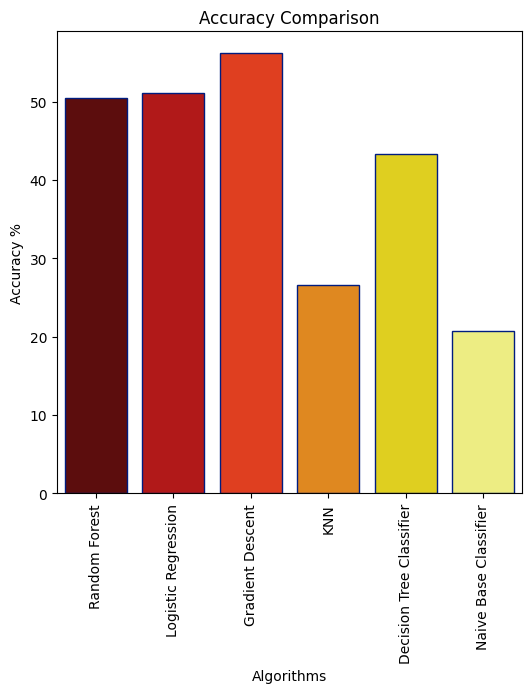

In [ ]:
plt.figure(figsize=(6,6))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
plt.xticks(rotation=90)
plt.title("Accuracy Comparison")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='hot',edgecolor=sns.color_palette('dark',7))
plt.show()

In [ ]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0

    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found')

    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')

    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')

    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J })

df = df.join(df.apply (lambda row: get_types (row),axis=1))
df.head(5)

,type,posts,no. of. words,stemmed_posts,IE,NS,TF,JP
0,INFJ,enfp intj moments sportscenter plays...,430,enfp intj moment sportscent play prank what be...,1,1,0,1
1,ENTP,finding lack these posts very alarming eo...,803,find lack these post veri alarm eostokendot bo...,0,1,1,0
2,INTP,good course which know thats bles...,253,good cours which know that bless curs eostoken...,1,1,1,0
3,INTJ,dear intp enjoyed conversation other eos...,777,dear intp enjoy convers other eostokendot esot...,1,1,1,1
4,ENTJ,youre fired eostokendot thats another silly...,402,your fire eostokendot that anoth silli misconc...,0,1,1,1


In [ ]:
#counting the no. of posts in one class/total no. of posts in the other class
print ("Introversion (I) /  Extroversion (E):\t", df['IE'].value_counts()[0], " / ", df['IE'].value_counts()[1])
print ("Intuition (N) / Sensing (S):\t\t", df['NS'].value_counts()[0], " / ", df['NS'].value_counts()[1])
print ("Thinking (T) / Feeling (F):\t\t", df['TF'].value_counts()[0], " / ", df['TF'].value_counts()[1])
print ("Judging (J) / Perceiving (P):\t\t", df['JP'].value_counts()[0], " / ", df['JP'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) / Sensing (S):		 1197  /  7478
Thinking (T) / Feeling (F):		 4694  /  3981
Judging (J) / Perceiving (P):		 5241  /  3434


In [ ]:
lemmatiser = WordNetLemmatizer()

# Remove the stop words for speed
useless_words = stopwords.words("english")

# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]


In [ ]:
# Splitting the MBTI personality into 4 letters and binarizing it

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    return [b_Pers[l] for l in personality]

#To show result output for personality prediction
def translate_back(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in df.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [ ]:
def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  len_data = len(data)
  i=0

  for row in data.iterrows():
      #Remove and clean comments
      posts = row[1].posts

      # Remove spaces > 1
      temp = re.sub(' +', ' ', posts).lower()

      #Remove stop words
      if remove_stop_words:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
      else:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])

      #Remove MBTI personality words from posts
      if remove_mbti_profiles:
          for t in unique_type_list:
              temp = temp.replace(t,"")

      # transform mbti to binary vector
      type_labelized = translate_personality(row[1].type) #or use lab_encoder.transform([row[1].type])[0]
      list_personality.append(type_labelized)
      # the cleaned data temp is passed here
      list_posts.append(temp)

  # returns the result
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

list_posts, list_personality  = pre_process_text(df, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", df.posts[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", df.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])

In [ ]:
nRow, nCol = list_personality.shape
print(f'There are {nRow} rows and no. of Personalities {nCol}')

There are 8675 rows and no. of Personalities 4


In [ ]:
#Vectorizing the database posts to a matrix of token counts for the model
cntizer = CountVectorizer(analyzer="word",
                             max_features=1000,
                             max_df=0.7,
                             min_df=0.1)
# the feature should be made of word n-gram
# Learn the vocabulary dictionary and return term-document matrix
print("Using CountVectorizer :")
X_cnt = cntizer.fit_transform(list_posts)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names_out()))
print("10 feature names can be seen below")
print(feature_names[0:10])

# For the Standardization or Feature Scaling Stage :-
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print(X_tfidf.shape)

Using CountVectorizer :
10 feature names can be seen below
[(0, 'ability'), (1, 'able'), (2, 'absolutely'), (3, 'across'), (4, 'action'), (5, 'actually'), (6, 'advice'), (7, 'agree'), (8, 'almost'), (9, 'alone')]

Using Tf-idf :
Now the dataset size is as below
(8675, 533)


In [ ]:
#counting top 10 words
reverse_dic = {}
for key in cntizer.vocabulary_:
    reverse_dic[cntizer.vocabulary_[key]] = key
top_10 = np.asarray(np.argsort(np.sum(X_cnt, axis=0))[0,-10:][0, ::-1]).flatten()
[reverse_dic[v] for v in top_10]

['feel',
 'type',
 'well',
 'friend',
 'want',
 'good',
 'love',
 'something',
 'also',
 'even']

In [ ]:
# Posts in tf-idf representation
X = X_tfidf
personality_type = ['IE', 'NS', 'TF', 'JP']
list_personality = list_personality.astype(int)

In [ ]:
#Random Forest model for MBTI dataset
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE Accuracy: 77.30%
NS Accuracy: 86.03%
TF Accuracy: 67.62%
JP Accuracy: 61.86%


In [ ]:
#XGBoost model for MBTI dataset
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE Accuracy: 75.90%
NS Accuracy: 85.57%
TF Accuracy: 66.50%
JP Accuracy: 59.62%


In [ ]:
# Stocastic Gradient Descent for MBTI dataset
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = SGDClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE Accuracy: 77.61%
NS Accuracy: 86.03%
TF Accuracy: 70.80%
JP Accuracy: 62.35%


In [ ]:
# Logistic Regression for MBTI dataset
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE Accuracy: 77.12%
NS Accuracy: 86.06%
TF Accuracy: 71.29%
JP Accuracy: 61.93%


In [ ]:
# KNN model for MBTI dataset
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE Accuracy: 76.67%
NS Accuracy: 85.99%
TF Accuracy: 54.52%
JP Accuracy: 40.94%


In [ ]:
# SVM model for MBTI dataset
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = SVC(random_state = 1)
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE Accuracy: 77.82%
NS Accuracy: 86.03%
TF Accuracy: 70.90%
JP Accuracy: 63.19%


In [ ]:
#Random Forest Model have the higest Accuracy so we will apply this model.

In [ ]:
my_posts  = """ Hi I am 21 years, currently, I am pursuing my graduate degree in computer science and management (Mba Tech CS ),
 It is a 5-year dual degree.... My CGPA to date is 3.8/4.0 .
I have a passion for teaching since childhood. Math has always been the subject of my interest in school.
Also, my mother has been one of my biggest inspirations for me.
She started her career as a teacher and now has her own education trust with preschools schools in Rural and Urban areas.
During the period of lockdown, I dwelled in the field of blogging and content creation on Instagram.  to spread love positivity kindness .
I hope I am able deliver my best to the platform and my optimistic attitude helps in the growth that is expected. Thank you for the opportunity. """

# The type is just a dummy so that the data prep function can be reused
mydata = pd.DataFrame(data={'type': ['INFJ'], 'posts': [my_posts]})

my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [ ]:
#Random Forest model for MBTI dataset
result = []
for l in range(len(personality_type)):
    print("%s classifier trained" % (personality_type[l]))

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # make predictions for my  data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])

IE classifier trained
NS classifier trained
TF classifier trained
JP classifier trained


In [ ]:
print("The result is: ", translate_back(result))

The result is:  INFP


In [ ]:
my_posts = """ They act like they care They tell me to share But when I carve the stories on my arm The doctor just calls it self harm I’m not asking for attention There’s a reason I have apprehensions I just need you to see What has become of me||| I know I’m going crazy But they think my thoughts are just hazy When in that chaos, in that confusion I’m crying out for help, to escape my delusions||| Mental health is a state of mind How does one keep that up when assistance is denied All my failed attempts to fight the blaze You treat it like its a passing phase||| Well stop, its not, because mental illness is real Understand that we’re all not made of steel Because when you brush these issues under the carpet You make it seem like its our mistake we’re not guarded||| Don’t you realise that its a problem that needs to be addressed Starting at home, in our nest Why do you keep your mouths shut about such things Instead of caring for those with broken wings||| What use is this social stigma When mental illness is not even such an enigma Look around and you’ll see the numbers of the affected hiding under the covers ||| This is an issue that needs to be discussed Not looked down upon with disgust Mental illness needs to be accepted So that people can be protected ||| Let me give you some direction People need affection The darkness must be escaped Only then the lost can be saved||| Bring in a change Something not very strange The new year is here Its time to eradicate fear||| Recognise the wrists under the knives To stop mental illness from taking more lives Let’s break the convention Start ‘suicide prevention’.||| Hoping the festival of lights drives the darkness of mental illness away"""
mydata = pd.DataFrame(data={'type': ['INFP'], 'posts': [my_posts]})
my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)
my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [ ]:
#Random Forest model for MBTI dataset
result = []
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    print("%s classifier trained" % (personality_type[l]))

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # make predictions for my  data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])

IE classifier trained
NS classifier trained
TF classifier trained
JP classifier trained


In [ ]:
print("The result is: ", translate_back(result))

The result is:  INTP


In [ ]:
import pickle

In [ ]:
with open('classifier.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
with open('cntizer.pkl', 'wb') as file:
    pickle.dump(cntizer, file)

In [ ]:
with open('tfizer.pkl', 'wb') as file:
    pickle.dump(tfizer, file)

In [ ]:
for l in range(len(personality_type)):
    # ... (Your training code here) ...

    if l == 0:
        with open('model_IE.pkl', 'wb') as file:
            pickle.dump(model, file)
    elif l == 1:
        with open('model_NS.pkl', 'wb') as file:
            pickle.dump(model, file)
    elif l == 2:
        with open('model_TF.pkl', 'wb') as file:
            pickle.dump(model, file)
    elif l == 3:
        with open('model_JP.pkl', 'wb') as file:
            pickle.dump(model, file)